# Problem 1.3: Voltage Peaks - data reader

The following is a small program to read the data file "data_VoltagePeaks.txt", which contains a single column: Voltage.

### Author & Date: 
- Troels C. Petersen (Niels Bohr Institute)
- 07-11-2021

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
from fitter import Fitter

In [2]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
# Read the data and print it to check it:
voltage = np.loadtxt("data_VoltagePeaks.txt")

print("Number of entries: ", len(voltage))
for i in range(10) : 
    print(f"  {voltage[i]:14.6f}")

Number of entries:  1000000
        1.119280
        1.828920
        0.797830
        2.715827
        1.496780
       12.176045
       24.154821
        1.981145
        0.677696
        0.604801


In [4]:
save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

In [111]:
N_voltage = 84721  # 本图xmin, xmax = 2.5, 3.5范围内voltage点的个数
Npeak = 7367     # Number of random Gaussian points
Nbkg  = 77354   # Number of random Exponential points

xmin, xmax = 11.7,12.2  # 图表显示的范围
Nbins = 100
binwidth = (xmax-xmin)/Nbins  #binwidth = (xmax-xmin)/Nbins
print(binwidth)

condition = (voltage<xmax)*(voltage>xmin)
x_all = voltage[condition]  # x_2是本图xmin, xmax = 2.5, 3.5范围内voltage点,x是将x_2 binned后的
print(np.size(x_all))
print(type(x_all))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.

# print(np.where(y==177))
print(x)
print(y)


0.005
3310
<class 'numpy.ndarray'>
[11.7025 11.7075 11.7125 11.7175 11.7225 11.7275 11.7325 11.7375 11.7425
 11.7475 11.7525 11.7575 11.7625 11.7675 11.7725 11.7775 11.7825 11.7875
 11.7925 11.7975 11.8025 11.8075 11.8125 11.8175 11.8225 11.8275 11.8325
 11.8375 11.8425 11.8475 11.8525 11.8575 11.8625 11.8675 11.8725 11.8775
 11.8825 11.8875 11.8925 11.8975 11.9025 11.9075 11.9125 11.9175 11.9225
 11.9275 11.9325 11.9375 11.9425 11.9475 11.9525 11.9575 11.9625 11.9675
 11.9725 11.9775 11.9825 11.9875 11.9925 11.9975 12.0025 12.0075 12.0125
 12.0175 12.0225 12.0275 12.0325 12.0375 12.0425 12.0475 12.0525 12.0575
 12.0625 12.0675 12.0725 12.0775 12.0825 12.0875 12.0925 12.0975 12.1025
 12.1075 12.1125 12.1175 12.1225 12.1275 12.1325 12.1375 12.1425 12.1475
 12.1525 12.1575 12.1625 12.1675 12.1725 12.1775 12.1825 12.1875 12.1925
 12.1975]
[27 34 28 36 39 29 34 32 37 26 25 37 26 26 37 34 37 34 32 39 41 31 32 27
 34 32 31 30 24 34 43 38 41 35 29 39 21 35 24 33 34 42 39 21 30 31 25 39
 43 61

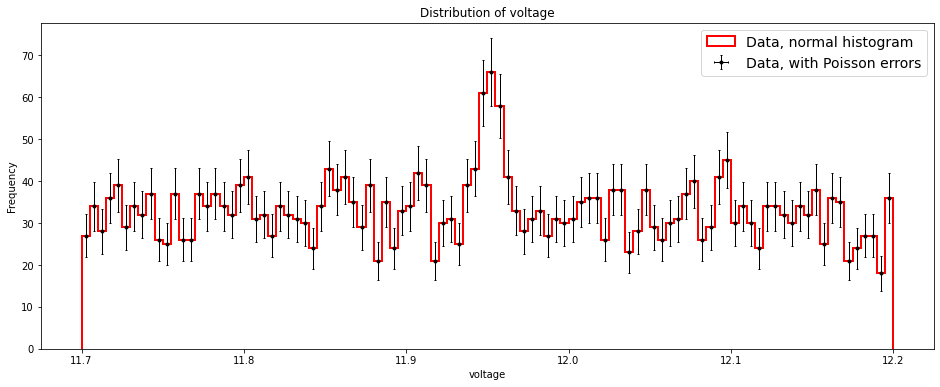

In [112]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2,color='red', label='Data, normal histogram')

ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="voltage",           # the label of the y axis
       ylabel="Frequency",           # the label of the y axis
       title="Distribution of voltage")    # the title of the plot
ax.legend(loc='best', fontsize=14);       # could also be # loc = 'upper right' e.g.


fig.savefig('fig1',dpi=600)

In [107]:
# Define your actual fitting function, with both background and signal in:
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * (1.0 / tau * np.exp(-x/tau))+ Ngauss * binwidth * (1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2))

In [108]:
Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(Nexp, tau, Ngauss, mu, sigma) :
    y_fit = fit_pdf(x, Nexp, tau, Ngauss, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)

minuit_chi2 = Minuit(chi2_owncalc, Nexp=Nbkg, tau=2.7, Ngauss=Npeak, mu=3.1, sigma=0.03) 
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.61                      │              Nfcn = 553              │
│ EDM = 1.36e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nexp   │  2.883e5  │  0.000e5  │            │            │         │         │       │
│ 1 │ tau    │  5.8945   │  0.0000   │            │            │         │         │       │
│ 2 │ Ngauss │  7.367e3  │  0.000e3  │            │            │         │         │       │
│ 3 │ mu     │    3.1    │    0.0    │            │            │         │         │       │
│ 4 │ sigma  │ 4.317e-2  │ 0.000e-2  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [109]:
# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_Nexp, fit_tau = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

Fit value: Nexp = 288296.80633 +/- 0.00000
Fit value: tau = 5.89450 +/- 0.00000
Fit value: Ngauss = 7367.00000 +/- 0.00000
Fit value: mu = 3.10000 +/- 0.00000
Fit value: sigma = 0.04317 +/- 0.00000
Chi2 value: 88.6   Ndof = 45    Prob(Chi2,Ndof) = 0.000


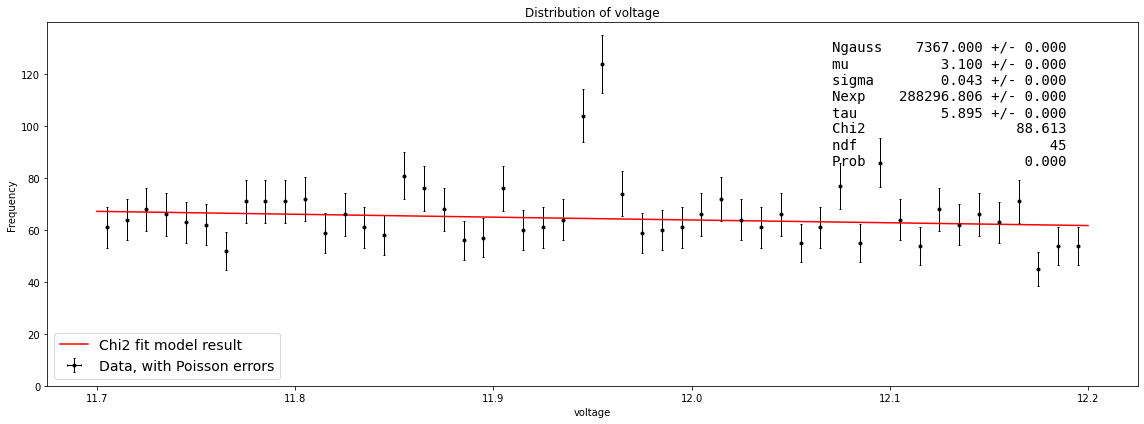

In [110]:

# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="voltage", # the label of the y axis
       ylabel="Frequency",  # the label of the y axis
       title="Distribution of voltage", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin,xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_chi2.values['Ngauss'], minuit_chi2.errors['Ngauss']],
     'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
     'sigma':    [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Nexp':     [minuit_chi2.values['Nexp'], minuit_chi2.errors['Nexp']],
     'tau':         [minuit_chi2.values['tau'], minuit_chi2.errors['tau']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }


#"%e" %
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.72, 0.95, text, ax, fontsize=14)
ax.legend(loc='lower left', fontsize=14); # could also be # loc = 'upper right' e.g.
fig.tight_layout()
fig.savefig('fig2',dpi=600)